In [1]:
import glob
import tensorflow as tf
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.misc import imresize, imsave, toimage
from PIL import Image
from skimage import transform

### Resize Input Images
All of the raw files are placed into the folder **data/raw/** as png format. The first code block cycles through these images and standardises them 

In [2]:
# Get a list of all the image files in the raw folder
def resize_files():
    filenames = glob.glob("../data/raw/*.png")

    filepaths_new = []
    for f in filenames:
        img = imread(f)
        img = imresize(img,(40,40))
        img = img[:,:,:3]
        f = f.replace("raw","resized")
        Image.fromarray(img).save(f)
        #imsave(f, arr='MxNx3', img)
        filepaths_new.append(f)

    print("Images resized")
    return filepaths_new

def dog_supply():
    filenames = glob.glob("../data/resized/*.png")
    filepaths_new = []
    for f in filenames:
        filepaths_new.append(f)
    return filepaths_new
    
# Uncomment this step if supplying new images
#filepaths_new = resize_files()

# Fallback on dog images already resized if not using 
filepaths_new = dog_supply()

In [3]:
def montage(images):    
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    elif len(images.shape) == 4 and images.shape[3] == 1:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 1)) * 0.5
    elif len(images.shape) == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    else:
        raise ValueError('Could not parse image shape of {}'.format(
            images.shape))
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m


def next_batch(num=16, data=filepaths_new):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [imread(data[i]) for i in idx]
    shuffled = np.asarray(data_shuffle)
    return np.asarray(data_shuffle)

In [4]:
tf.reset_default_graph()
batch_size = 16
n_noise = 16

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 40, 40, 3], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 40, 40, 3])
        x = tf.layers.conv2d(x, kernel_size=5, filters=256, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=128, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x
    
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.9
    with tf.variable_scope("generator", reuse=None):
        x = z
        
        d1 = 4#3
        d2 = 3
        
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[10, 10])
        
        
        
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=256, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=128, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=3, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x

In [5]:
g = generator(noise, keep_prob, is_training)
print(g)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))

loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.0002).minimize(loss_g + g_reg, var_list=vars_g)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Tensor("generator/conv2d_transpose_3/Sigmoid:0", shape=(?, 40, 40, 3), dtype=float32)


  0%|          | 0/20 [00:00<?, ?it/s]

0 0.69644386 0.6906806


 50%|█████     | 10/20 [00:44<00:44,  4.43s/it]

10 0.69400316 0.6937674


100%|██████████| 20/20 [01:28<00:00,  4.43s/it]


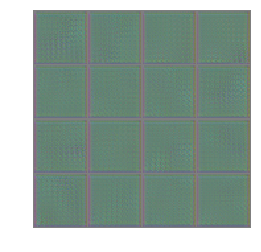

In [6]:
# This is set to 20 just to test the setup
# 60000 iterations would be a suitable long experiment to run
for i in tqdm(range(20)):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
     
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [b for b in next_batch(num=batch_size)]  

    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_fake_ls_init = d_fake_ls
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
        
    if g_ls * 1.35 < d_ls:
        train_g = False
        pass
    if d_ls * 1.35 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 10:
        print (i, d_ls, g_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_imgs = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,:] for img in gen_imgs]
        m = montage(imgs)
        plt.axis('off')
        plt.imshow(m, cmap='gray')
        plt.savefig('../data/output/'+str(i)+'.png')